<a href="https://colab.research.google.com/github/oshbocker/CAFA/blob/main/CAFA_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"oshbocker","key":"bb9c6a60ba5c39e689d8cf8d15cb8bca"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!pip install obonet -q
!pip install biopython -q
!pip install torchmetrics -q

In [ ]:
import os
import torch

from pathlib import Path


iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

cafa_main_path = Path("cafa-5-protein-function-prediction")
cafa_clean_fasta_path = Path("viktorfairuschin/cafa-5-fasta-files")
esm2_path = Path("viktorfairuschin/cafa-5-ems-2-embeddings-numpy")
protbert_path = Path("henriupton/protbert-embeddings-for-cafa5")
t5_path = Path("sergeifironov/t5embeds")

data_paths = [cafa_clean_fasta_path, esm2_path, protbert_path, t5_path]

if iskaggle:
  content_dir = "/kaggle/input"
else:
  content_dir = "/content"

class CFG:
    train_go_obo_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/go-basic.obo"
    train_seq_fasta_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_sequences.fasta"
    train_terms_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_terms.tsv"
    train_taxonomy_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv"
    train_ia_path: str = f"{content_dir}/cafa-5-protein-function-prediction/IA.txt"
    test_sequences_path: str = f"{content_dir}/Test (Targets)/testsuperset.fasta"

    num_labels = 500
    n_epochs = 14
    batch_size = 128
    lr = 0.0005

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
if not iskaggle:
  import zipfile,kaggle
  if not cafa_main_path.exists():
    print(cafa_main_path)
    kaggle.api.competition_download_cli(str(cafa_main_path))
    zipfile.ZipFile(f'{cafa_main_path}.zip').extractall(cafa_main_path)
  for data_path in data_paths:
    if not data_path.exists():
      print(data_path)
      kaggle.api.dataset_download_files(str(data_path))
      zipfile.ZipFile(f'{data_path.name}.zip').extractall(data_path.name)

viktorfairuschin/cafa-5-fasta-files
viktorfairuschin/cafa-5-ems-2-embeddings-numpy
henriupton/protbert-embeddings-for-cafa5
sergeifironov/t5embeds


In [ ]:
import obonet
import time

import networkx as nx
import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

In [ ]:
graph = obonet.read_obo(CFG.train_go_obo_path)

In [ ]:
# Information Accretion values for terms
ia_dict = {}
with open(CFG.train_ia_path) as f:
    for line in f:
        (key, value) = line.split("\t")
        ia_dict[key] = float(value.replace("\n",""))

In [ ]:
subontology_roots = {'BPO':'GO:0008150',
                     'CCO':'GO:0005575',
                     'MFO':'GO:0003674'}

BPO_len = len(nx.ancestors(graph, subontology_roots['BPO']))
CCO_len = len(nx.ancestors(graph, subontology_roots['CCO']))
MFO_len = len(nx.ancestors(graph, subontology_roots['MFO']))
print(BPO_len, CCO_len, MFO_len, BPO_len + CCO_len + MFO_len)

27941 4042 11262 43245


In [ ]:
train_terms = pd.read_csv(CFG.train_terms_path, sep="\t")
train_terms['ia'] = train_terms['term'].apply(lambda x: ia_dict[x])
print(train_terms.shape)
train_terms.head(5)

(5363863, 4)


,EntryID,term,aspect,ia
0,A0A009IHW8,GO:0008152,BPO,1.598544
1,A0A009IHW8,GO:0034655,BPO,0.042274
2,A0A009IHW8,GO:0072523,BPO,0.083901
3,A0A009IHW8,GO:0044270,BPO,0.281155
4,A0A009IHW8,GO:0006753,BPO,0.013844


## Get the leaf predictions for each protein
A leaf prediction is a GO term that doesn't have any children that are also predictions for the protein.

In [ ]:
def get_leaf_labels(train_terms, aspect):
    # Group by protein and get a list of all go term predictions
    protein_list_go_term = train_terms[train_terms['aspect'] == aspect].groupby('EntryID')['term'].apply(list)

    leaf_labels = {}
    for i, protein in enumerate(protein_list_go_term.index):
        test_terms = set(protein_list_go_term[protein])
        descendants = set()
        for term in test_terms:
            descendants.update(nx.descendants(graph, term))

        specific_labels = test_terms.difference(descendants)
        leaf_labels[protein] = list(specific_labels)

    return leaf_labels

from collections import deque

# Get ordered list of all ancestors
def leaf_label_ancestors(graph, leaf_labels):
    ordered_edges_dict = {}
    for label in leaf_labels:
        # Get ancestors
        ordered_edges = deque()
        node_is_root = False
        prev_node_id = label
        while node_is_root == False:
            node = graph.nodes[prev_node_id]
            node_is_root = 'is_a' not in node
            if not node_is_root:
                prev_node_id = node['is_a'][0]
                ordered_edges.appendleft(prev_node_id)
        ordered_edges_dict[label] = ordered_edges

    return ordered_edges_dict

In [ ]:
def get_next_label(rw, depth=1):
    if not rw['labeled'] and len(rw['ordered_edges']) > depth:
        return rw['ordered_edges'][-depth]
    else:
        return rw['balanced_label']

def is_final_balanced_label(rw, balanced_labels, depth=1):
    if not rw['labeled']:
        return (rw['balanced_label'] in balanced_labels) or (len(rw['ordered_edges']) == depth)
    else:
        return True

def get_balanced_labels(label_df, label_count_threshold):
    df = label_df.copy()
    balanced_labels = set([label for label, count in df['label'].value_counts().items()
                           if count >= label_count_threshold])
    df['labeled'] = df['label'].apply(lambda x: x in balanced_labels)
    df['balanced_label'] = df['label'] # df.apply(lambda x: x['label'] if x['labeled'] == True else None, axis=1)
    print(sum(df['labeled'])/df.shape[0])
    print(len(balanced_labels))
    print(df['balanced_label'].value_counts())
    depth = 1
    while sum(df['labeled'])/df.shape[0] < 1:
        df['balanced_label'] = df.apply(lambda x: get_next_label(x, depth=depth), axis=1)
        balanced_labels = set([label for label, count in df['balanced_label'].value_counts().items()
                                   if count >= label_count_threshold])
        df['labeled'] = df.apply(lambda x: is_final_balanced_label(x, balanced_labels, depth=depth), axis=1)
        depth += 1
        print(sum(df['labeled'])/df.shape[0])
        print(len(balanced_labels))
        print(df['balanced_label'].value_counts())

    return df, df['balanced_label'].nunique() - 1

### Cellular Component Labels (CCO)

In [ ]:
CCO_leaf_labels = get_leaf_labels(train_terms, 'CCO')
print("leaf_labels: ", len(CCO_leaf_labels.values()))
CCO_all_leaf_labels = np.unique(np.concatenate(list(CCO_leaf_labels.values())))
print("unique leaf_labels: ", len(CCO_all_leaf_labels))
CCO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'cellular_component']
CCO_ordered_edges = leaf_label_ancestors(graph, CCO_nodes)

# Get the first node label
CCO_data_with_labels = []
# Get all CCO labeled proteins with leaf labels
for protein, label_list in CCO_leaf_labels.items():
    for label in label_list:
        CCO_data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': CCO_ordered_edges[label]})

CCO_df = pd.DataFrame(CCO_data_with_labels)

new_CCO_df, CCO_num_labels = get_balanced_labels(CCO_df, 500)

leaf_labels:  92912
unique leaf_labels:  2763
0.612107597944911
47
GO:0005829    16981
GO:0005634    12661
GO:0005886    11509
GO:0005737     8335
GO:0005654     8160
              ...  
GO:0036030        1
GO:0036028        1
GO:0061834        1
GO:0036027        1
GO:0071202        1
Name: balanced_label, Length: 2763, dtype: int64
0.7935857682819184
65
GO:0005829    16981
GO:0005634    12725
GO:0005886    11823
GO:0110165    10149
GO:0005737     8406
              ...  
GO:0035449        1
GO:0044174        1
GO:0005879        1
GO:0044384        1
GO:0098539        1
Name: balanced_label, Length: 690, dtype: int64
0.9047031663762081
71
GO:0005829    17050
GO:0110165    14188
GO:0005634    12910
GO:0005886    11823
GO:0005737     8418
              ...  
GO:0031252        1
GO:0032994        1
GO:0035448        1
GO:0033176        1
GO:1990077        1
Name: balanced_label, Length: 294, dtype: int64
0.961806577190322
72
GO:0005829    17050
GO:0110165    16038
GO:0005634    12938
GO:

## Molecular Function Labels (MFO)

In [ ]:
MFO_leaf_labels = get_leaf_labels(train_terms, 'MFO')
print("leaf labels: ", len(MFO_leaf_labels.values()))
MFO_all_leaf_labels = np.unique(np.concatenate(list(MFO_leaf_labels.values())))
print("unique leaf labels: ", len(MFO_all_leaf_labels))
MFO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'molecular_function']
MFO_ordered_edges = leaf_label_ancestors(graph, MFO_nodes)

# Get the first node label
MFO_data_with_labels = []
# Get all MFO labeled proteins with leaf labels
for protein, label_list in MFO_leaf_labels.items():
  # proteins with only protein binding GO:0005515 bias the dataset
  if label_list != ['GO:0005515']:
    for label in label_list:
        MFO_data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': MFO_ordered_edges[label]})

MFO_df = pd.DataFrame(MFO_data_with_labels)

new_MFO_df, MFO_num_labels = get_balanced_labels(MFO_df, 500)

leaf labels:  78637
unique leaf labels:  6866
0.30495570563985613
23
GO:0005515    11529
GO:0042802     3998
GO:0042803     1632
GO:0003729     1491
GO:0003723     1356
              ...  
GO:0047102        1
GO:0140692        1
GO:0102207        1
GO:0090499        1
GO:0102627        1
Name: balanced_label, Length: 6866, dtype: int64
0.5329707920357863
43
GO:0005515    16348
GO:0042802     3998
GO:0003723     2072
GO:0003677     1955
GO:0000976     1900
              ...  
GO:0005199        1
GO:0004376        1
GO:0001884        1
GO:0015067        1
GO:0050485        1
Name: balanced_label, Length: 1537, dtype: int64
0.715428471186738
56
GO:0005515    18352
GO:0042802     3998
GO:0003677     2622
GO:0003723     2549
GO:0005488     2172
              ...  
GO:0015278        1
GO:0001882        1
GO:0019842        1
GO:0005345        1
GO:0016409        1
Name: balanced_label, Length: 593, dtype: int64
0.8756074028593983
62
GO:0005515    18791
GO:0005488     4119
GO:0042802     3998


## Biological Process Labels (BPO)

In [ ]:
BPO_leaf_labels = get_leaf_labels(train_terms, 'BPO')
print("leaf_labels: ", len(BPO_leaf_labels.values()))
BPO_all_leaf_labels = np.unique(np.concatenate(list(BPO_leaf_labels.values())))
print("unique leaf_labels: ", len(BPO_all_leaf_labels))
BPO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'biological_process']
BPO_ordered_edges = leaf_label_ancestors(graph, BPO_nodes)

# Get the first node label
BPO_data_with_labels = []
# Get all BPO labeled proteins with leaf labels
for protein, label_list in BPO_leaf_labels.items():
    for label in label_list:
        BPO_data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': BPO_ordered_edges[label]})

BPO_df = pd.DataFrame(BPO_data_with_labels)

new_BPO_df, BPO_num_labels = get_balanced_labels(BPO_df, 500)

leaf_labels:  92210
unique leaf_labels:  17978
0.07192198699783298
27
GO:0045944    2473
GO:0000122    1691
GO:0006355    1322
GO:0045893    1233
GO:0045892    1150
              ... 
GO:1904303       1
GO:1903235       1
GO:0098746       1
GO:0071911       1
GO:0009709       1
Name: balanced_label, Length: 17978, dtype: int64
0.28241706951158524
87
GO:0048856    3858
GO:0045944    2615
GO:0003006    2573
GO:0006950    2359
GO:0009987    2006
              ... 
GO:0045472       1
GO:0042435       1
GO:0009149       1
GO:0032534       1
GO:0046813       1
Name: balanced_label, Length: 6474, dtype: int64
0.5790698449741624
140
GO:0009987    5701
GO:0048856    5636
GO:0006950    3888
GO:0003006    3672
GO:0048513    3644
              ... 
GO:0071880       1
GO:0051304       1
GO:0046823       1
GO:0010566       1
GO:0019062       1
Name: balanced_label, Length: 2757, dtype: int64
0.7876979496582763
155
GO:0009987    8764
GO:0048856    7102
GO:0050794    4863
GO:0030154    4471
GO:0009966

## Classify selected nodes of CCO

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def get_labels_df(balanced_label_df):
  ohe_df = pd.get_dummies(balanced_label_df, prefix=['balanced_label'], columns=['balanced_label'], drop_first=True)
  label_cols = [c for c in ohe_df.columns if 'balanced_label_' in c]
  label_df = ohe_df.groupby('protein').sum(numeric_only=True)[label_cols].clip(0,1)
  label_values = list(label_df.values)
  label_ids = list(label_df.index)
  labels_df = pd.DataFrame(data={"EntryID": label_ids, "labels_vect": label_values})
  return labels_df, label_cols

CCO_labels_df, CCO_label_cols = get_labels_df(new_CCO_df)
MFO_labels_df, MFO_label_cols = get_labels_df(new_MFO_df)
BPO_labels_df, BPO_label_cols = get_labels_df(new_BPO_df)
# Split into train, val, test
# X_train, X_test, y_train, y_test = train_test_split(label_ids,
#                                                     label_values,
#                                                     test_size = 0.2)
# print("Train label", len(y_train))
# print("Test label", len(y_test))

In [ ]:
# Directories for the different embedding vectors :
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "ESM2" : "cafa-5-ems-2-embeddings-numpy"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "ESM2" : 1280,
    "Concat": 1280+1024,
}

In [ ]:
class ProteinSequenceDataset(Dataset):

    def __init__(self, datatype, embeddings_source, subontology):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype
        self.subontology = subontology

        if embeddings_source in ["ProtBERT", "ESM2"]:
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "T5":
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "Concat":
            bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
            bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
            esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
            esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
            t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
            t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")
            esm2_sorted_ids, esm2_sorted_embeds = map(list,zip(*list(sorted(zip(esm2_ids, esm2_embeds), key=lambda x: x[0]))))
            t5_sorted_ids, t5_sorted_embeds = map(list,zip(*list(sorted(zip(t5_ids, t5_embeds), key=lambda x: x[0]))))
            # t5 includes the same embedding twic
            if datatype == "test":
              del t5_sorted_ids[632]
              del t5_sorted_embeds[632]
            embeds = np.concatenate([esm2_sorted_embeds, t5_sorted_embeds], axis=1)
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": t5_sorted_ids, "embed" : embeds_list})
        else:
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})


        if subontology=="CCO":
            self.df = self.df.merge(CCO_labels_df, on="EntryID")
        if subontology=="MFO":
            self.df = self.df.merge(MFO_labels_df, on="EntryID")
        if subontology=="BPO":
            self.df = self.df.merge(BPO_labels_df, on="EntryID")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [ ]:
datatype = "test"
bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")

In [ ]:
esm2_sorted_ids, esm2_sorted_embeds = map(list,zip(*list(sorted(zip(esm2_ids, esm2_embeds), key=lambda x: x[0]))))
t5_sorted_ids, t5_sorted_embeds = map(list,zip(*list(sorted(zip(t5_ids, t5_embeds), key=lambda x: x[0]))))

In [ ]:
print(len(esm2_sorted_ids))
print(len(t5_sorted_ids))

141864
141865


In [ ]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes, p):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 4*1012)
        self.activation1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(p)
        self.linear2 = torch.nn.Linear(4*1012, 4*712)
        self.activation2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(p)
        self.linear3 = torch.nn.Linear(4*712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        return x


class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train_model(embeddings_source, subontology, num_labels, model_type="linear", train_size=0.9):

    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source, subontology=subontology)

    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=CFG.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=CFG.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=num_labels, p=0.2).to(CFG.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=num_labels).to(CFG.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=num_labels).to(CFG.device)
    n_epochs = CFG.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]

    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)

        ## VALIDATION PHASE :
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)

        scheduler.step(avg_loss)
        print("\n")

    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])

    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}

    return model, losses_history, scores_history

In [ ]:
# cat_CCO_model, cat_CCO_losses, cat_CCO_scores = train_model(embeddings_source="Concat", subontology="CCO", num_labels=CCO_num_labels, model_type="linear")

In [ ]:
# esm2_model, esm2_losses, esm2_scores = train_model(embeddings_source="ESM2",model_type="linear")

In [ ]:
# Weighted F1 Score?

In [ ]:
t5_CCO_model, t5_CCO_losses, t5_CCO_scores = train_model(embeddings_source="T5", subontology="CCO", num_labels=CCO_num_labels, model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:14<00:00, 45.58it/s]


Running Average TRAIN Loss :  5.412046439057097
Running Average TRAIN F1-Score :  0.11094137997187059
Running Average VAL Loss :  5.156589103071657
Running Average VAL F1-Score :  0.13395949738891158


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 48.83it/s]


Running Average TRAIN Loss :  4.968950069643307
Running Average TRAIN F1-Score :  0.14103314429749408
Running Average VAL Loss :  5.015792817285616
Running Average VAL F1-Score :  0.14722686495682966


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 47.91it/s]


Running Average TRAIN Loss :  4.77484155867807
Running Average TRAIN F1-Score :  0.15611739143364656
Running Average VAL Loss :  4.912569646965967
Running Average VAL F1-Score :  0.15824369320722476


EPOCH  4


100%|██████████| 654/654 [00:13<00:00, 48.45it/s]


Running Average TRAIN Loss :  4.607885552108835
Running Average TRAIN F1-Score :  0.17002645694289004
Running Average VAL Loss :  4.841535747867741
Running Average VAL F1-Score :  0.16845796777777475


EPOCH  5


100%|██████████| 654/654 [00:13<00:00, 49.31it/s]


Running Average TRAIN Loss :  4.446308870563449
Running Average TRAIN F1-Score :  0.1837742944854662
Running Average VAL Loss :  4.814108391330667
Running Average VAL F1-Score :  0.1775106477410826


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 49.63it/s]


Running Average TRAIN Loss :  4.287282025777601
Running Average TRAIN F1-Score :  0.198020880466572
Running Average VAL Loss :  4.7583798055779445
Running Average VAL F1-Score :  0.18404023328872576


EPOCH  7


100%|██████████| 654/654 [00:13<00:00, 48.77it/s]


Running Average TRAIN Loss :  4.132655911489365
Running Average TRAIN F1-Score :  0.2119762712935789
Running Average VAL Loss :  4.734621626057037
Running Average VAL F1-Score :  0.19362546809732098


EPOCH  8


100%|██████████| 654/654 [00:13<00:00, 48.94it/s]


Running Average TRAIN Loss :  3.9828943681279454
Running Average TRAIN F1-Score :  0.22574755025383894
Running Average VAL Loss :  4.7390658104256405
Running Average VAL F1-Score :  0.199109407116289


EPOCH  9


100%|██████████| 654/654 [00:13<00:00, 49.44it/s]


Running Average TRAIN Loss :  3.8449024567181183
Running Average TRAIN F1-Score :  0.2382654747057034
Running Average VAL Loss :  4.780625163692317
Running Average VAL F1-Score :  0.20220068097114563


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 49.10it/s]


Running Average TRAIN Loss :  3.519554696680938
Running Average TRAIN F1-Score :  0.2568447693772272
Running Average VAL Loss :  4.757363975864568
Running Average VAL F1-Score :  0.21536776382629186


EPOCH  11


100%|██████████| 654/654 [00:13<00:00, 49.18it/s]


Running Average TRAIN Loss :  3.4348227131986473
Running Average TRAIN F1-Score :  0.2649772945757306
Running Average VAL Loss :  4.770903430572928
Running Average VAL F1-Score :  0.2192058893915725


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 49.10it/s]


Running Average TRAIN Loss :  3.3753168134514344
Running Average TRAIN F1-Score :  0.2695406407391259
Running Average VAL Loss :  4.761899761957665
Running Average VAL F1-Score :  0.2206306861688013


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 48.62it/s]


Running Average TRAIN Loss :  3.3733228918973825
Running Average TRAIN F1-Score :  0.2701009607415316
Running Average VAL Loss :  4.776605073719809
Running Average VAL F1-Score :  0.22022908762709736


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 49.09it/s]


Running Average TRAIN Loss :  3.363084751167064
Running Average TRAIN F1-Score :  0.2715473543476621
Running Average VAL Loss :  4.7607394701814
Running Average VAL F1-Score :  0.21924697597549386


TRAINING FINISHED
FINAL TRAINING SCORE :  0.2715473543476621
FINAL VALIDATION SCORE :  0.21924697597549386


In [ ]:
# protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="T5",model_type="linear")

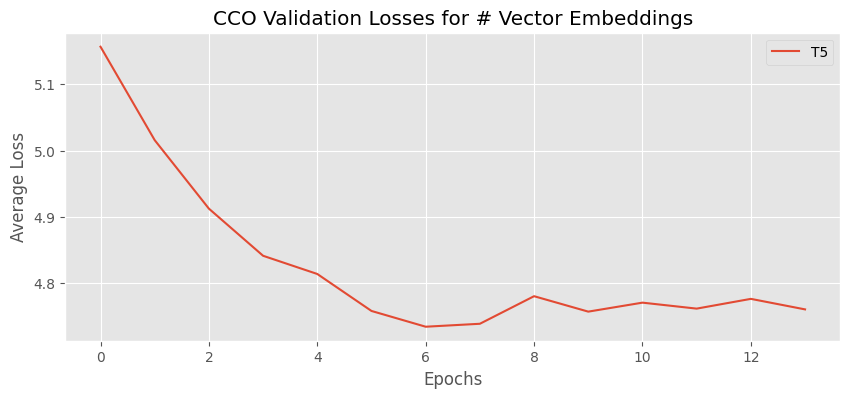

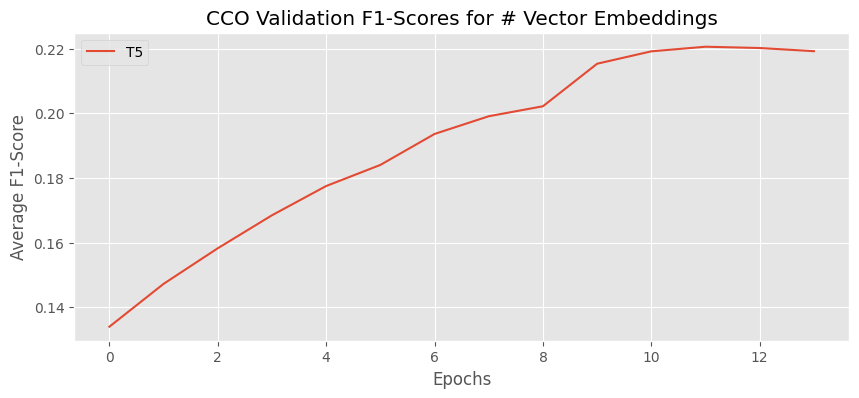

In [50]:
plt.figure(figsize = (10, 4))
# plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_CCO_losses["val"], label = "T5")
# plt.plot(protbert_losses["val"], label = "ProtBERT")
# plt.plot(cat_CCO_losses["val"], label = "Concat")
plt.title("CCO Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
# plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_CCO_scores["val"], label = "T5")
# plt.plot(protbert_scores["val"], label = "ProtBERT")
# plt.plot(cat_CCO_scores["val"], label = "Concat")
plt.title("CCO Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [ ]:
# cat_MFO_model, cat_MFO_losses, cat_MFO_scores = train_model(embeddings_source="Concat", subontology="MFO", num_labels=MFO_num_labels, model_type="linear")

In [ ]:
t5_MFO_model, t5_MFO_losses, t5_MFO_scores = train_model(embeddings_source="T5", subontology="MFO", num_labels=MFO_num_labels, model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 422/422 [00:08<00:00, 48.52it/s]


Running Average TRAIN Loss :  4.846190390993634
Running Average TRAIN F1-Score :  0.089207178493741
Running Average VAL Loss :  4.343475362087818
Running Average VAL F1-Score :  0.11410809070505995


EPOCH  2


100%|██████████| 422/422 [00:08<00:00, 48.29it/s]


Running Average TRAIN Loss :  4.144495994558832
Running Average TRAIN F1-Score :  0.1253398197451474
Running Average VAL Loss :  4.1015363500473345
Running Average VAL F1-Score :  0.13439899223281981


EPOCH  3


100%|██████████| 422/422 [00:08<00:00, 47.79it/s]


Running Average TRAIN Loss :  3.907630997246476
Running Average TRAIN F1-Score :  0.14614402430388035
Running Average VAL Loss :  3.969674343758441
Running Average VAL F1-Score :  0.15325326012804152


EPOCH  4


100%|██████████| 422/422 [00:08<00:00, 49.31it/s]


Running Average TRAIN Loss :  3.7340881061779942
Running Average TRAIN F1-Score :  0.16436030000660093
Running Average VAL Loss :  3.873750575045322
Running Average VAL F1-Score :  0.16649386064803345


EPOCH  5


100%|██████████| 422/422 [00:08<00:00, 48.86it/s]


Running Average TRAIN Loss :  3.5681370937428767
Running Average TRAIN F1-Score :  0.17973997071385384
Running Average VAL Loss :  3.8024638510764914
Running Average VAL F1-Score :  0.18357025181993525


EPOCH  6


100%|██████████| 422/422 [00:08<00:00, 48.57it/s]


Running Average TRAIN Loss :  3.436686015242084
Running Average TRAIN F1-Score :  0.19450576970645037
Running Average VAL Loss :  3.780393960628104
Running Average VAL F1-Score :  0.19244089278768986


EPOCH  7


100%|██████████| 422/422 [00:08<00:00, 48.93it/s]


Running Average TRAIN Loss :  3.3025905515345353
Running Average TRAIN F1-Score :  0.2075913786817501
Running Average VAL Loss :  3.744429978918522
Running Average VAL F1-Score :  0.20181930160268824


EPOCH  8


100%|██████████| 422/422 [00:08<00:00, 48.47it/s]


Running Average TRAIN Loss :  3.180596465748068
Running Average TRAIN F1-Score :  0.22221159126380044
Running Average VAL Loss :  3.7499879623981234
Running Average VAL F1-Score :  0.2112328936444952


EPOCH  9


100%|██████████| 422/422 [00:08<00:00, 48.48it/s]


Running Average TRAIN Loss :  3.065075227434601
Running Average TRAIN F1-Score :  0.23368264845974074
Running Average VAL Loss :  3.7534394213493836
Running Average VAL F1-Score :  0.22848064785308025


EPOCH  10


100%|██████████| 422/422 [00:08<00:00, 49.06it/s]


Running Average TRAIN Loss :  2.8060820088567326
Running Average TRAIN F1-Score :  0.24853968789792175
Running Average VAL Loss :  3.6983805768033293
Running Average VAL F1-Score :  0.23082842630274752


EPOCH  11


100%|██████████| 422/422 [00:08<00:00, 49.31it/s]


Running Average TRAIN Loss :  2.7345637580229774
Running Average TRAIN F1-Score :  0.2536667884985135
Running Average VAL Loss :  3.6950690188306443
Running Average VAL F1-Score :  0.235632542282977


EPOCH  12


100%|██████████| 422/422 [00:08<00:00, 49.19it/s]


Running Average TRAIN Loss :  2.70378496127106
Running Average TRAIN F1-Score :  0.2574629331828576
Running Average VAL Loss :  3.698305018404697
Running Average VAL F1-Score :  0.23757692315477005


EPOCH  13


100%|██████████| 422/422 [00:08<00:00, 48.98it/s]


Running Average TRAIN Loss :  2.6774359325662043
Running Average TRAIN F1-Score :  0.2607253175493665
Running Average VAL Loss :  3.7027238987861795
Running Average VAL F1-Score :  0.23687629465093005


EPOCH  14


100%|██████████| 422/422 [00:08<00:00, 47.92it/s]


Running Average TRAIN Loss :  2.6419053382783138
Running Average TRAIN F1-Score :  0.2624590328025027
Running Average VAL Loss :  3.698994753208566
Running Average VAL F1-Score :  0.24102230877318281


TRAINING FINISHED
FINAL TRAINING SCORE :  0.2624590328025027
FINAL VALIDATION SCORE :  0.24102230877318281


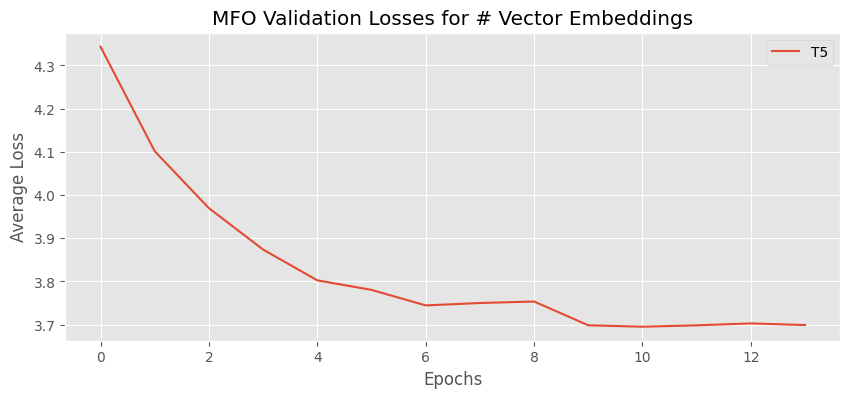

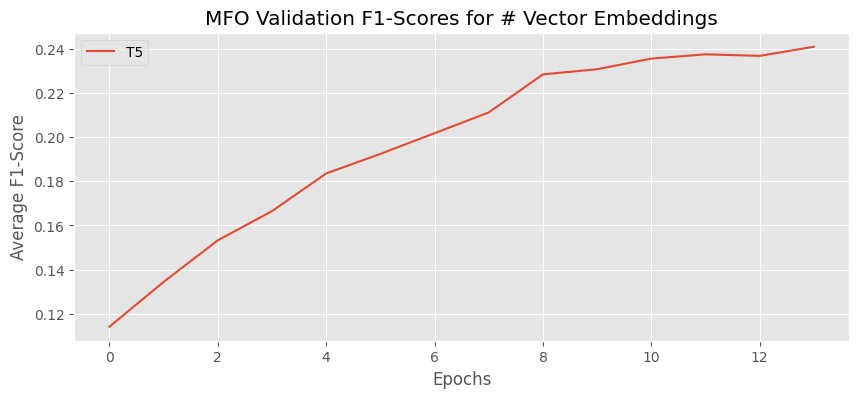

In [51]:
plt.figure(figsize = (10, 4))
# plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_MFO_losses["val"], label = "T5")
# plt.plot(protbert_losses["val"], label = "ProtBERT")
# plt.plot(cat_MFO_losses["val"], label = "Concat")
plt.title("MFO Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
# plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_MFO_scores["val"], label = "T5")
# plt.plot(protbert_scores["val"], label = "ProtBERT")
# plt.plot(cat_MFO_scores["val"], label = "Concat")
plt.title("MFO Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [ ]:
# cat_BPO_model, cat_BPO_losses, cat_BPO_scores = train_model(embeddings_source="Concat", subontology="BPO", num_labels=BPO_num_labels, model_type="linear")

In [ ]:
t5_BPO_model, t5_BPO_losses, t5_BPO_scores = train_model(embeddings_source="T5", subontology="BPO", num_labels=BPO_num_labels, model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 649/649 [00:13<00:00, 47.55it/s]


Running Average TRAIN Loss :  12.31424660675331
Running Average TRAIN F1-Score :  0.07240037802888083
Running Average VAL Loss :  11.620701776791925
Running Average VAL F1-Score :  0.08454348672538588


EPOCH  2


100%|██████████| 649/649 [00:13<00:00, 48.44it/s]


Running Average TRAIN Loss :  11.63371453924429
Running Average TRAIN F1-Score :  0.09368222263083435
Running Average VAL Loss :  11.430063495897267
Running Average VAL F1-Score :  0.09415327941309916


EPOCH  3


100%|██████████| 649/649 [00:13<00:00, 48.11it/s]


Running Average TRAIN Loss :  11.299854014063103
Running Average TRAIN F1-Score :  0.10473473521612459
Running Average VAL Loss :  11.270485642838151
Running Average VAL F1-Score :  0.10356467477466962


EPOCH  4


100%|██████████| 649/649 [00:13<00:00, 48.43it/s]


Running Average TRAIN Loss :  10.997012073710813
Running Average TRAIN F1-Score :  0.11558627811345187
Running Average VAL Loss :  11.040953851725957
Running Average VAL F1-Score :  0.11172291593090312


EPOCH  5


100%|██████████| 649/649 [00:13<00:00, 48.56it/s]


Running Average TRAIN Loss :  10.70484582227992
Running Average TRAIN F1-Score :  0.12696536215960705
Running Average VAL Loss :  10.930039542995088
Running Average VAL F1-Score :  0.11881172118631944


EPOCH  6


100%|██████████| 649/649 [00:13<00:00, 47.73it/s]


Running Average TRAIN Loss :  10.407460189196287
Running Average TRAIN F1-Score :  0.139065226118076
Running Average VAL Loss :  10.871041219528408
Running Average VAL F1-Score :  0.12540398298265182


EPOCH  7


100%|██████████| 649/649 [00:13<00:00, 48.05it/s]


Running Average TRAIN Loss :  10.120922431740077
Running Average TRAIN F1-Score :  0.15160361826649432
Running Average VAL Loss :  10.883802139595764
Running Average VAL F1-Score :  0.13345493223160915


EPOCH  8


100%|██████████| 649/649 [00:13<00:00, 48.72it/s]


Running Average TRAIN Loss :  9.842113419196272
Running Average TRAIN F1-Score :  0.16422909323717302
Running Average VAL Loss :  10.675456857028072
Running Average VAL F1-Score :  0.14031462146811288


EPOCH  9


100%|██████████| 649/649 [00:13<00:00, 47.57it/s]


Running Average TRAIN Loss :  9.577103755874516
Running Average TRAIN F1-Score :  0.1765365594386687
Running Average VAL Loss :  10.669486385502227
Running Average VAL F1-Score :  0.1458298523642429


EPOCH  10


100%|██████████| 649/649 [00:13<00:00, 48.27it/s]


Running Average TRAIN Loss :  9.328628664207752
Running Average TRAIN F1-Score :  0.18849368065090502
Running Average VAL Loss :  10.631015490179193
Running Average VAL F1-Score :  0.15194617347051836


EPOCH  11


100%|██████████| 649/649 [00:13<00:00, 47.99it/s]


Running Average TRAIN Loss :  9.089387142052084
Running Average TRAIN F1-Score :  0.19948340424312097
Running Average VAL Loss :  10.719729083858125
Running Average VAL F1-Score :  0.15793548738711502


EPOCH  12


100%|██████████| 649/649 [00:13<00:00, 47.79it/s]


Running Average TRAIN Loss :  8.873048520786185
Running Average TRAIN F1-Score :  0.21054305037474963
Running Average VAL Loss :  10.741849866631913
Running Average VAL F1-Score :  0.16085500356881585


EPOCH  13


100%|██████████| 649/649 [00:13<00:00, 48.00it/s]


Running Average TRAIN Loss :  8.34411796546313
Running Average TRAIN F1-Score :  0.22649843623439778
Running Average VAL Loss :  10.740546631486449
Running Average VAL F1-Score :  0.16785198506223012


EPOCH  14


100%|██████████| 649/649 [00:13<00:00, 48.48it/s]


Running Average TRAIN Loss :  8.234833078134592
Running Average TRAIN F1-Score :  0.23353356173482992
Running Average VAL Loss :  10.66758307365522
Running Average VAL F1-Score :  0.17177356233539648


TRAINING FINISHED
FINAL TRAINING SCORE :  0.23353356173482992
FINAL VALIDATION SCORE :  0.17177356233539648


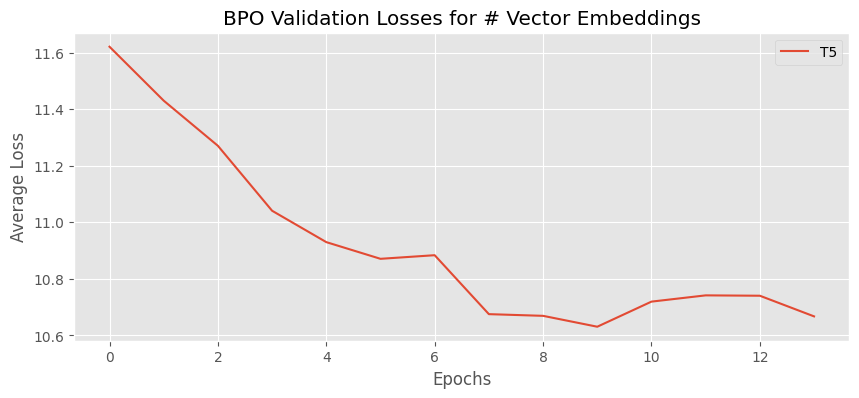

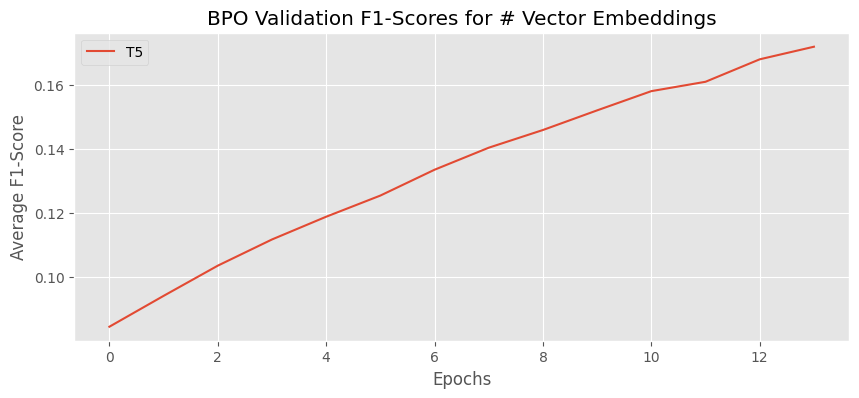

In [52]:
plt.figure(figsize = (10, 4))
# plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_BPO_losses["val"], label = "T5")
# plt.plot(protbert_losses["val"], label = "ProtBERT")
# plt.plot(cat_BPO_losses["val"], label = "Concat")
plt.title("BPO Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
# plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_BPO_scores["val"], label = "T5")
# plt.plot(protbert_scores["val"], label = "ProtBERT")
# plt.plot(cat_BPO_scores["val"], label = "Concat")
plt.title("BPO Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

## Make Predictions

In [ ]:
model_map = {
    "CCO": {
        "T5": t5_CCO_model,
        # "ProtBERT": protbert_CCO_model,
        # "ESM2": esm2_CCO_model,
        # "Concat": cat_CCO_model,
        "labels": CCO_label_cols,
        "num_labels": CCO_num_labels,
    },
    "MFO": {
        "T5": t5_MFO_model,
        # "ProtBERT": protbert_MFO_model,
        # "ESM2": esm2_MFO_model,
        # "Concat": cat_MFO_model,
        "labels": MFO_label_cols,
        "num_labels": MFO_num_labels,
    },
    "BPO": {
        "T5": t5_BPO_model,
        # "ProtBERT": protbert_MFO_model,
        # "ESM2": esm2_MFO_model,
        # "Concat": cat_BPO_model,
        "labels": BPO_label_cols,
        "num_labels": BPO_num_labels,
    }
}

In [ ]:
def predict(embeddings_source, subontology):

    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source, subontology=subontology)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

    model = model_map[subontology][embeddings_source]
    label_cols = model_map[subontology]["labels"]
    num_labels = model_map[subontology]["num_labels"]

    model.eval()

    labels = pd.read_csv(CFG.train_terms_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = [label.split('_')[-1] for label in label_cols]
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(CFG.device)
        confs_[i*num_labels:(i+1)*num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*num_labels:(i+1)*num_labels] = id[0]
        go_terms_[i*num_labels:(i+1)*num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [ ]:
CCO_submission_df = predict("T5", "CCO")
print(len(CCO_submission_df))
print(len(CCO_submission_df["GO term"].unique()))
CCO_submission_df.head()

GENERATE PREDICTION FOR TEST SET...


55581it [00:44, 1257.21it/s]


PREDICTIONS DONE
4057413
73


,Id,GO term,Confidence
0,Q9CQV8,GO:0000325,0.012230
1,Q9CQV8,GO:0000785,0.022415
2,Q9CQV8,GO:0005576,0.102638
3,Q9CQV8,GO:0005615,0.378559
4,Q9CQV8,GO:0005618,0.033643


In [ ]:
MFO_submission_df = predict("T5", "MFO")
print(len(MFO_submission_df))
print(len(MFO_submission_df["GO term"].unique()))
MFO_submission_df.head()

GENERATE PREDICTION FOR TEST SET...


39741it [00:32, 1234.38it/s]


PREDICTIONS DONE
3377985
85


,Id,GO term,Confidence
0,Q9CQV8,GO:0000976,0.268112
1,Q9CQV8,GO:0000978,0.180540
2,Q9CQV8,GO:0000981,0.030541
3,Q9CQV8,GO:0001228,0.014568
4,Q9CQV8,GO:0003677,0.680044


In [ ]:
BPO_submission_df = predict("T5", "BPO")
print(len(BPO_submission_df))
print(len(BPO_submission_df["GO term"].unique()))
BPO_submission_df.head()

GENERATE PREDICTION FOR TEST SET...


53593it [00:44, 1210.04it/s]


PREDICTIONS DONE
9110810
170


,Id,GO term,Confidence
0,Q9CQV8,GO:0000122,0.649941
1,Q9CQV8,GO:0000904,0.440541
2,Q9CQV8,GO:0001666,0.020515
3,Q9CQV8,GO:0001817,0.008107
4,Q9CQV8,GO:0001819,0.054463


In [ ]:
id_list = []
go_term_list = []
confidence_list = []
for rw in CCO_submission_df.values:
  edges = CCO_ordered_edges[rw[1]]
  for edge in edges:
    id_list.append(rw[0])
    go_term_list.append(edge)
    confidence_list.append(rw[2])
additional_labels = pd.DataFrame({'Id': id_list, 'GO term': go_term_list, 'Confidence': confidence_list})

In [ ]:
submission_df = pd.concat([CCO_submission_df, MFO_submission_df, BPO_submission_df,]).drop_duplicates(['Id', 'GO term']).reset_index(drop=True)

In [ ]:
print(len(submission_df))
print(len(submission_df["GO term"].unique()))
submission_df.head()

16546208
328


,Id,GO term,Confidence
0,Q9CQV8,GO:0000325,0.012230
1,Q9CQV8,GO:0000785,0.022415
2,Q9CQV8,GO:0005576,0.102638
3,Q9CQV8,GO:0005615,0.378559
4,Q9CQV8,GO:0005618,0.033643


In [ ]:
submission_df['Id'].unique()[:5]

array(['Q9CQV8', 'P62259', 'P68510', 'P61982', 'O70456'], dtype=object)

In [ ]:
protein_id = 'P68510'
subset_df = submission_df[submission_df['Id'] == protein_id].reset_index(drop=True)

In [ ]:
subset_df.loc[subset_df['Confidence'].argmax()]

Id                P68510
GO term       GO:0005515
Confidence      0.943715
Name: 95, dtype: object

In [ ]:
subset_df.sort_values(['Confidence'], ascending=False).head(7)

,Id,GO term,Confidence
95,P68510,GO:0005515,0.943715
122,P68510,GO:0019904,0.903426
120,P68510,GO:0019899,0.900047
22,P68510,GO:0005829,0.880448
68,P68510,GO:0110165,0.857196
140,P68510,GO:0046982,0.852274
5,P68510,GO:0005634,0.839800


In [ ]:
train_terms[(train_terms['EntryID'] == protein_id) & (train_terms['aspect'] == 'CCO')]

,EntryID,term,aspect,ia
4032360,P68510,GO:0005622,CCO,0.366945
4032361,P68510,GO:0060076,CCO,4.520144
4032362,P68510,GO:0014704,CCO,0.525320
4032363,P68510,GO:0044291,CCO,3.752804
4032364,P68510,GO:0005575,CCO,0.000000
4032365,P68510,GO:0098984,CCO,2.297752
4032366,P68510,GO:0098978,CCO,1.802445
4032367,P68510,GO:0032279,CCO,0.102393
4032368,P68510,GO:0005829,CCO,1.545978
4032369,P68510,GO:0150048,CCO,1.415037


In [ ]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)